# **Step-1 Preprocessing**

## **Importing libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import RFE
import time
import warnings
warnings.filterwarnings("ignore")

## **Import dataset**

In [ ]:
dataset = pd.read_csv('/content/HEY.CSV')
print(dataset.head())

       Lat  Lat dir      Long  Long dir        Date      Time
0  9.570306       N  78.106903        E  30-04-2024  08:29:11
1  0.000000     NaN   0.000000      NaN  30-04-2024  08:29:30
2  9.570318       N  78.106887        E  30-04-2024  08:29:31
3  9.570319       N  78.106887        E  30-04-2024  08:29:32
4  9.570319       N  78.106887        E  30-04-2024  08:29:33


## **Handling missing values and feature creation**

In [ ]:
# Handle missing values for Lat and Long columns
dataset['Lat '] = dataset['Lat '].replace(0, np.nan)
dataset['Long '] = dataset['Long '].replace(0, np.nan)
dataset['Lat '].ffill(inplace=True)
dataset['Long '].ffill(inplace=True)
dataset['Lat dir'].ffill(inplace=True)
dataset['Long dir'].ffill(inplace=True)

# Handle categorical features
dataset['Latdir_N'] = dataset['Lat dir'].apply(lambda x: 1 if x == 'N' else 0)
dataset['Latdir_S'] = dataset['Lat dir'].apply(lambda x: 1 if x == 'S' else 0)
dataset['Longdir_E'] = dataset['Long dir'].apply(lambda x: 1 if x == 'E' else 0)
dataset['Longdir_W'] = dataset['Long dir'].apply(lambda x: 1 if x == 'W' else 0)

# Handle missing values for Date and Time columns
dataset['Date'] = dataset['Date'].replace('-', np.nan)
dataset['Time'] = dataset['Time'].replace('-', np.nan)
dataset.dropna(subset=['Date', 'Time'], inplace=True)
dataset = dataset[~((dataset['Date'] == '0/0/0') & (dataset['Time'] == '0:0:0'))]

# Format Date and Time columns
dataset['Date'] = pd.to_datetime(dataset['Date'], errors='coerce')
dataset['Time'] = pd.to_timedelta(dataset['Time'], errors='coerce')

# Check for any remaining NaNs
if dataset.isnull().sum().any():
    print("Warning: There are still missing values in the dataset.")
    print(dataset.isnull().sum())

# Create additional features
reference_date = pd.to_datetime('1900-01-01')
dataset['Days_from_ref'] = (dataset['Date'] - reference_date).dt.days
dataset['Seconds_from_midnight'] = dataset['Time'].dt.total_seconds()
dataset['HourOfDay'] = dataset['Seconds_from_midnight'] // 3600

# Create time period features
dataset['Morning'] = ((dataset['HourOfDay'] >= 6) & (dataset['HourOfDay'] < 12)).astype(int)
dataset['Afternoon'] = ((dataset['HourOfDay'] >= 12) & (dataset['HourOfDay'] < 18)).astype(int)
dataset['Evening'] = ((dataset['HourOfDay'] >= 18) & (dataset['HourOfDay'] < 21)).astype(int)
dataset['Night'] = ((dataset['HourOfDay'] >= 21) | (dataset['HourOfDay'] < 6)).astype(int)

# Create interaction term and sinusoidal transformations
dataset['HourDayInteraction'] = dataset['HourOfDay'] * dataset['Date'].dt.dayofweek
dataset['Time_sin'] = np.sin(2 * np.pi * dataset['Seconds_from_midnight'] / 86400)
dataset['Time_cos'] = np.cos(2 * np.pi * dataset['Seconds_from_midnight'] / 86400)
dataset['Interaction_Seconds_Days'] = dataset['Seconds_from_midnight'] * dataset['Days_from_ref']

# Day of the week
day_of_week = dataset['Date'].dt.dayofweek
dataset['Monday'] = (day_of_week == 0).astype(int)
dataset['Tuesday'] = (day_of_week == 1).astype(int)
dataset['Wednesday'] = (day_of_week == 2).astype(int)
dataset['Thursday'] = (day_of_week == 3).astype(int)
dataset['Friday'] = (day_of_week == 4).astype(int)
dataset['Saturday'] = (day_of_week == 5).astype(int)
dataset['Sunday'] = (day_of_week == 6).astype(int)
dataset['Isweekend'] =(day_of_week == 5).astype(int)
dataset['Isweekend'] =(day_of_week == 6).astype(int)

# Extract features and target variables
X = dataset[['Interaction_Seconds_Days', 'Days_from_ref', 'Seconds_from_midnight', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Isweekend', 'Morning', 'Afternoon', 'Evening', 'Night', 'HourDayInteraction', 'Time_sin', 'Time_cos']].values
y = dataset[['Lat ', 'Long ', 'Latdir_N', 'Latdir_S', 'Longdir_E', 'Longdir_W']].values

# Apply log transformation to all numeric columns in X and y
X = np.log1p(X)
y = np.log1p(y)

# Check shapes of X and y
print("\nShape of X:", X.shape)
print("\nX", X[:5])
print("Shape of y:", y.shape)
print("\ny", y[:5])



Shape of X: (4791, 18)

X [[21.05064032 10.72350965 10.32718543  0.          0.69314718  0.
   0.          0.          0.          0.          0.          0.69314718
   0.          0.          0.          2.19722458  0.58529331 -0.93122812]
 [21.05126204 10.72350965 10.32780713  0.          0.69314718  0.
   0.          0.          0.          0.          0.          0.69314718
   0.          0.          0.          2.19722458  0.58482649 -0.93401985]
 [21.05129475 10.72350965 10.32783984  0.          0.69314718  0.
   0.          0.          0.          0.          0.          0.69314718
   0.          0.          0.          2.19722458  0.58480189 -0.93416692]
 [21.05132746 10.72350965 10.32787255  0.          0.69314718  0.
   0.          0.          0.          0.          0.          0.69314718
   0.          0.          0.          2.19722458  0.58477729 -0.934314  ]
 [21.05136017 10.72350965 10.32790525  0.          0.69314718  0.
   0.          0.          0.          0.      

## **Correlation matrix**

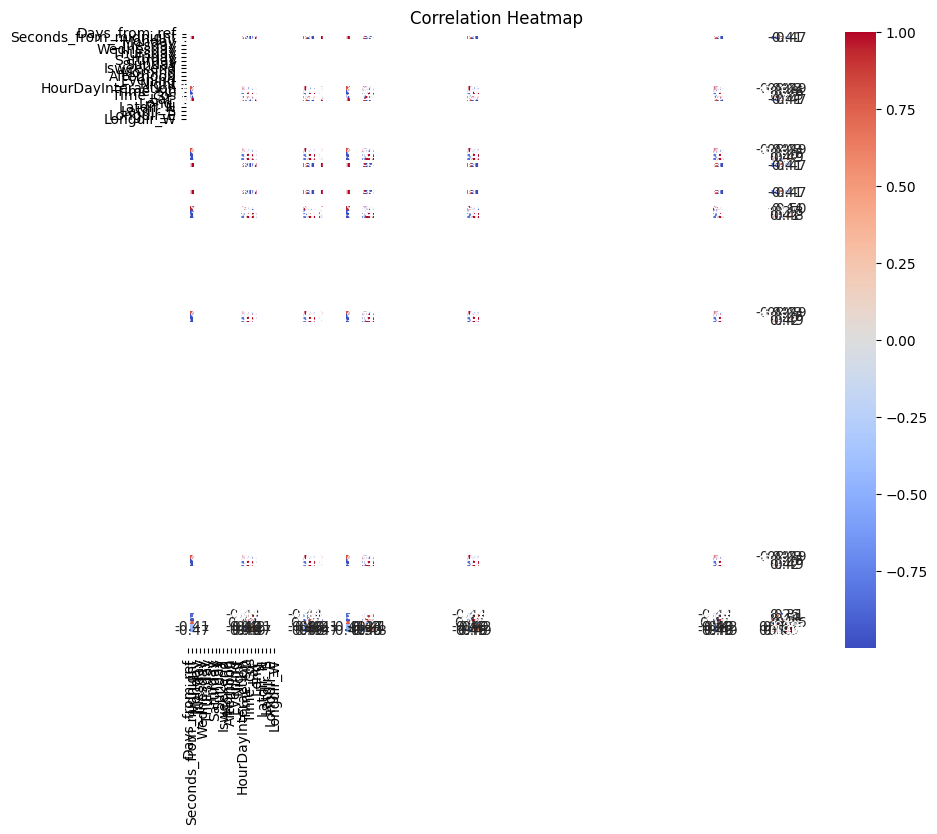

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the correlation matrix function
def correlation_matrix(X, y):
    # Concatenate X and y to form a single matrix
    data = np.concatenate((X, y), axis=1)
    # Calculate the correlation matrix
    corr_matrix = np.corrcoef(data, rowvar=False)
    return corr_matrix

# Calculate the correlation matrix
corr_matrix = correlation_matrix(X, y)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=['Days_from_ref', 'Seconds_from_midnight', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Isweekend', 'Morning', 'Afternoon', 'Evening', 'Night', 'HourDayInteraction', 'Time_sin', 'Time_cos'] + ['Lat ', 'Long ', 'Latdir_N', 'Latdir_S', 'Longdir_E', 'Longdir_W'], yticklabels=['Days_from_ref', 'Seconds_from_midnight', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Isweekend', 'Morning', 'Afternoon', 'Evening', 'Night', 'HourDayInteraction', 'Time_sin', 'Time_cos'] + ['Lat ', 'Long ', 'Latdir_N', 'Latdir_S', 'Longdir_E', 'Longdir_W'])
plt.title('Correlation Heatmap')
plt.show()


Feature Importances from RandomForestRegressor:
                     Feature    Importance
17                  Time_cos  3.096417e-01
0   Interaction_Seconds_Days  2.698891e-01
16                  Time_sin  2.231027e-01
2      Seconds_from_midnight  1.973666e-01
15        HourDayInteraction  5.564945e-12
3                     Monday  0.000000e+00
4                    Tuesday  0.000000e+00
5                  Wednesday  0.000000e+00
6                   Thursday  0.000000e+00
7                     Friday  0.000000e+00
8                   Saturday  0.000000e+00
1              Days_from_ref  0.000000e+00
10                 Isweekend  0.000000e+00
11                   Morning  0.000000e+00
12                 Afternoon  0.000000e+00
13                   Evening  0.000000e+00
14                     Night  0.000000e+00
9                     Sunday  0.000000e+00


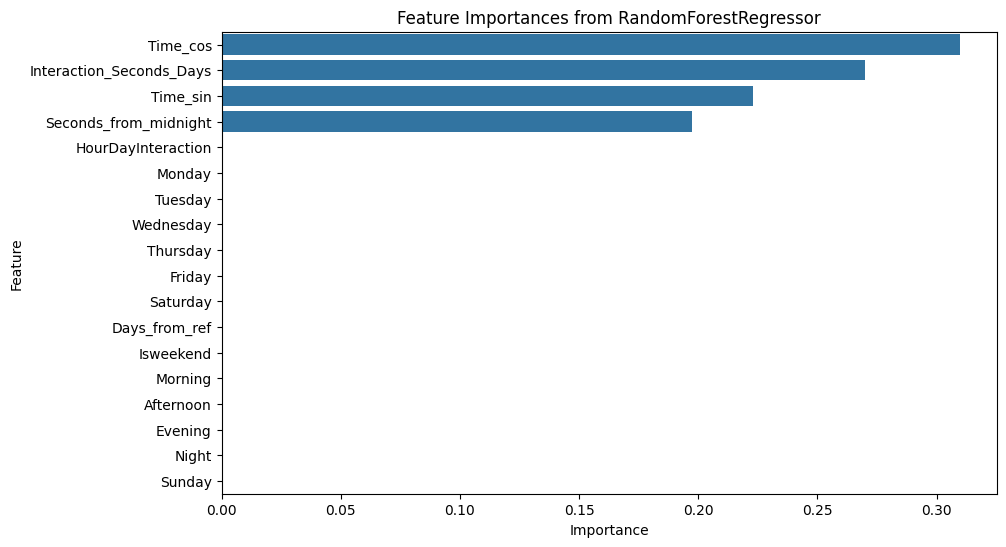

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# Instantiate the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=1)

# Fit the model on the training data
rf_model.fit(X, y)

# Get feature importances from the model
feature_importances = rf_model.feature_importances_

# Define the feature names
features = ['Interaction_Seconds_Days', 'Days_from_ref', 'Seconds_from_midnight', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Isweekend', 'Morning', 'Afternoon', 'Evening', 'Night', 'HourDayInteraction', 'Time_sin', 'Time_cos']

# Create a DataFrame to store feature names and importances
feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances from RandomForestRegressor:")
print(feature_importances_df)

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Feature Importances from XGBoost:
                     Feature  Importance
16                  Time_sin    0.688053
0   Interaction_Seconds_Days    0.311870
15        HourDayInteraction    0.000077
1              Days_from_ref    0.000000
14                     Night    0.000000
13                   Evening    0.000000
12                 Afternoon    0.000000
11                   Morning    0.000000
10                 Isweekend    0.000000
9                     Sunday    0.000000
8                   Saturday    0.000000
7                     Friday    0.000000
6                   Thursday    0.000000
5                  Wednesday    0.000000
4                    Tuesday    0.000000
3                     Monday    0.000000
2      Seconds_from_midnight    0.000000
17                  Time_cos    0.000000


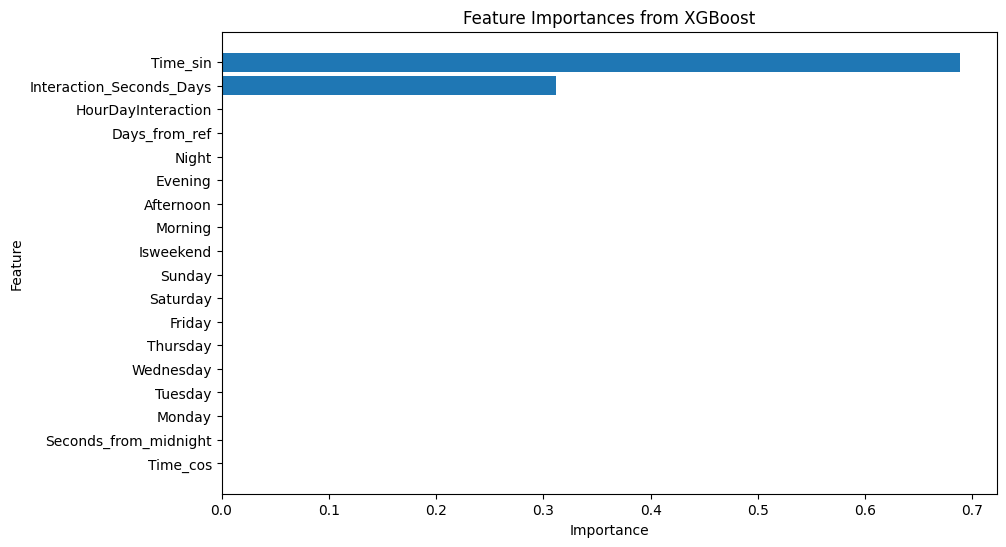

In [ ]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd

# Train an XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Get feature importance scores
feature_importances = xgb_model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
features = ['Interaction_Seconds_Days', 'Days_from_ref', 'Seconds_from_midnight', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Isweekend', 'Morning', 'Afternoon', 'Evening', 'Night', 'HourDayInteraction', 'Time_sin', 'Time_cos']
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances from XGBoost:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBoost')
plt.gca().invert_yaxis()
plt.show()


## **Train Test split**

In [ ]:
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("Shape of X_train:", X_train_unscaled.shape)
print("Shape of X_test:", X_test_unscaled.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3832, 18)
Shape of X_test: (959, 18)
Shape of y_train: (3832, 6)
Shape of y_test: (959, 6)


## **Feature scaling**

In [ ]:
# Scaling the features (X)
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train_unscaled)
X_test = X_scaler.transform(X_test_unscaled)


# Scaling the target variables (y) using a separate scaler
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)
"""
print(X_train_unscaled)
print("\n")
print(X_train)

print("\n")
print("\n")
print(X_test_unscaled)
print("\n")
print(X_test)

print("\n")
print("\n")
print(y_train_unscaled)
print("\n")
print(y_train)

print("\n")
print("\n")
print(y_test_unscaled)
print("\n")
print(y_test)"""

'\nprint(X_train_unscaled)\nprint("\n")\nprint(X_train)\n\nprint("\n")\nprint("\n")\nprint(X_test_unscaled)\nprint("\n")\nprint(X_test)\n\nprint("\n")\nprint("\n")\nprint(y_train_unscaled)\nprint("\n")\nprint(y_train)\n\nprint("\n")\nprint("\n")\nprint(y_test_unscaled)\nprint("\n")\nprint(y_test)'

## **Model evaluation metrics**

In [ ]:
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def calculate_adjusted_r2(y_true, y_pred):
    n = len(y_true)
    k = 2
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

def print_evaluation_metrics(y_true, y_pred, model):
    mse = calculate_mse(y_true, y_pred)
    mae = calculate_mae(y_true, y_pred)
    rmse = calculate_rmse(y_true, y_pred)
    r2 = calculate_r2(y_true, y_pred)
    adjusted_r2 = calculate_adjusted_r2(y_true, y_pred)

    model_name = type(model).__name__
    print(f"Model: {model_name}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2): {r2}")
    print(f"Adjusted R-squared (Adjusted R2): {adjusted_r2}")

def plot_predictions(y_train_true, y_train_pred, y_test_true, y_test_pred, model):
    plt.figure(figsize=(14, 6))

    # Training set
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_true, y_train_pred, alpha=0.5)
    plt.plot([y_train_true.min(), y_train_true.max()], [y_train_true.min(), y_train_true.max()], 'r--')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.title(f'Training Set: Predicted vs Actual\nModel: {type(model).__name__}')
    plt.grid(True)

    # Test set
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_true, y_test_pred, alpha=0.5)
    plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'r--')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.title(f'Test Set: Predicted vs Actual\nModel: {type(model).__name__}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#print("Training Set Evaluation Metrics:")
#print_evaluation_metrics(y_train, y_train_pred, n_train, k)

#print("\nTest Set Evaluation Metrics:")
#print_evaluation_metrics(y_test, y_test_pred, n_test, k)

# plot_predictions(y_train, y_train_pred, y_test, y_test_pred, model)